In [1]:
import tushare as ts
import pandas as pd
pro = ts.pro_api()

In [2]:
li = pd.read_excel('../data_h2.xlsx')
inli = pd.read_excel('../data/IDX_Idxtrd.xlsx')
inli['Iddate'] = inli['Iddate'].apply(lambda x:x.replace('-',''))#沪深创指数信息

In [ ]:
#data1 = pro.stock_basic(exchange='', list_status='D', fields='ts_code,symbol,name,area,industry,list_date,list_status,delist_date')
stock_list = pro.stock_basic(exchange='', list_status='L',fields='ts_code,name,market,industry,list_date')
#data3 = pro.stock_basic(exchange='', list_status='P', fields='ts_code,symbol,name,area,industry,list_date,list_status,delist_date')
#stock_list = data1.append([data2,data3])

In [ ]:
def series_2_str(sr):
    '这是把股票序列变为逗号分隔tushare所需的用的'
    a = ''
    for i in sr:
        a=a+i+','
    return a

def series_2_str_2(sr):
    '这是把股票序列变为逗号分隔tushare所需的用的'
    a = ''
    b = ''
    for i in range(100):
        a=a+sr[i:i+1].values[0]+','
    for i in range(100,(len(sr)-1)):
        b = b+sr[i:i+1].values[0]+','
    return a,b

def index_list(industry,o_date):
    '获得同类型市场数据_输出股票列表'
    sl = stock_list[(stock_list['industry'] == industry) & (stock_list['list_date'].astype(int) < int(o_date))] #目前还在上市且该行业的股票列表
    return sl['ts_code']

def get_cp(tscode,tprq,time):
    '获得li数据内的详细时序数据'
    df = pro.daily(ts_code=tscode, start_date=str(tprq-10000), end_date=str(tprq))
    return df[:time]

In [ ]:
#获得市场指数
def get_market(tscode):
    if(tscode[0] == '6'):
        return 1
    elif(tscode[0] == '3'):
        return 399006
    elif(tscode[0] == '0'):
        return 399001
def get_index_chg(market,start_date,end_date):
    inli2 = inli[(inli['Indexcd'] == market) & (inli['Iddate'].astype(int) <= int(end_date)) & (inli['Iddate'].astype(int) >= int(start_date))]
    return inli2[['Iddate','Idchg']]

In [ ]:
for i in li.index:
    print('正在搞',i)
    t_c = li['ts_code'][i]
    t_i = li['industry'][i]
    t_t = li['tingpai'][i]

    sample = get_cp(t_c,t_t,40)
    start_d = sample['trade_date'][0:1].values[0]
    end_d = sample['trade_date'][-1:].values[0]

    st_series = index_list(t_i,start_d)
    print(len(st_series))
    if(len(st_series)<100):
        st_str = series_2_str(st_series)
        bbb = pro.daily(ts_code = st_str,start_date=start_d, end_date=end_d)
    else:
        st_str,st_str2 = series_2_str_2(st_series)
        bbb = pro.daily(ts_code = st_str,start_date=start_d, end_date=end_d)
        bbb2 = pro.daily(ts_code = st_str2,start_date=start_d, end_date=end_d)
        bbb = bbb.append(bbb2)

In [6]:
print('正在搞',35)
t_c = li['ts_code'][35]
t_i = li['industry'][35]
t_t = li['tingpai'][35]

sample = get_cp(t_c,t_t,40)
sample = sample.sort_values(by='trade_date')
start_d = sample['trade_date'][0:1].values[0]
end_d = sample['trade_date'][-1:].values[0]

st_series = index_list(t_i,start_d)
print(len(st_series))
if(len(st_series)<100):
    st_str = series_2_str(st_series)
    bbb = pro.daily(ts_code = st_str,start_date=start_d, end_date=end_d)
else:
    st_str,st_str2 = series_2_str_2(st_series)
    bbb = pro.daily(ts_code = st_str,start_date=start_d, end_date=end_d)
    bbb2 = pro.daily(ts_code = st_str2,start_date=start_d, end_date=end_d)
    bbb = bbb.append(bbb2)

正在搞 35
96


In [7]:
idchg = get_index_chg(get_market(t_c),start_d,end_d)
sample = pd.merge(sample,idchg,left_on = 'trade_date',right_on='Iddate' ,how='left')

In [8]:
qwe = bbb.groupby('trade_date')[['pre_close','close']].sum()
qwe['machg'] = (qwe['close']/qwe['pre_close']) - 1
sample = pd.merge(sample,qwe['machg'],left_on = 'trade_date',right_index= True,how='left')

In [16]:
from arch import arch_model

In [17]:
returns = 100 * sample['close'].pct_change().dropna()

In [18]:
am = arch_model(returns,vol= 'EGARCH')

In [19]:
am

Constant Mean(constant: yes, no. of exog: 0, volatility: EGARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x28292db5c08

In [20]:
res=am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 143.7174308561281
Iteration:      2,   Func. Count:     13,   Neg. LLF: 452386347.3221315
Iteration:      3,   Func. Count:     20,   Neg. LLF: 100.26067829810123
Iteration:      4,   Func. Count:     26,   Neg. LLF: 91.00920594590008
Iteration:      5,   Func. Count:     31,   Neg. LLF: 91.1048818059418
Iteration:      6,   Func. Count:     37,   Neg. LLF: 90.87134427783124
Iteration:      7,   Func. Count:     42,   Neg. LLF: 90.54843811558892
Iteration:      8,   Func. Count:     47,   Neg. LLF: 90.52063271374807
Iteration:      9,   Func. Count:     52,   Neg. LLF: 90.52770200076469
Iteration:     10,   Func. Count:     58,   Neg. LLF: 90.4978689963629
Iteration:     11,   Func. Count:     63,   Neg. LLF: 90.49512057882534
Iteration:     12,   Func. Count:     68,   Neg. LLF: 90.49504574064731
Iteration:     13,   Func. Count:     73,   Neg. LLF: 90.49504470333487
Iteration:     14,   Func. Count:     77,   Neg. LLF: 90.49504470

In [21]:
res.summary

<bound method ARCHModelResult.summary of                      Constant Mean - EGARCH Model Results                     
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -90.4950
Distribution:                  Normal   AIC:                           188.990
Method:            Maximum Likelihood   BIC:                           195.644
                                        No. Observations:                   39
Date:                Sun, Mar 21 2021   Df Residuals:                       38
Time:                        14:04:27   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0908      0.

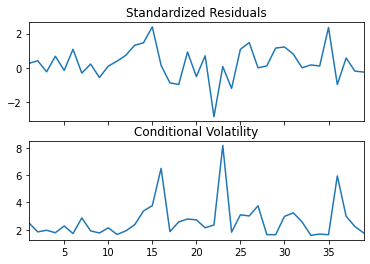

In [22]:
fig = res.plot()

In [23]:
b = res.resid

In [25]:
b.to_csv('sds.csv')